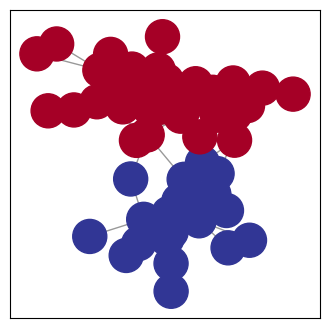

data/given/dolphins.gml passed
data/given/football.gml passed
data/given/karate.gml passed
data/given/krebs.gml passed
data/net.in passed
data/MAP.gml passed
data/other/adjnoun.gml passed
data/other/netscience.mtx passed
data/other/lesmis.gml passed
data/other/polbooks.mtx passed
data/other/celegansneural.mtx passed


In [2]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
from scipy.io import mmread
from networkx.algorithms import community


def read_network_matrix(filename):
    with open(filename, "r") as f:
        net = {}
        n = int(f.readline())
        net['noNodes'] = n
        mat = []
        for i in range(n):
            mat.append([])
            line = f.readline()
            elems = line.split(" ")
            for j in range(n):
                mat[-1].append(int(elems[j]))
        net["mat"] = mat 
        degrees = []
        noEdges = 0
        for i in range(n):
            d = 0
            for j in range(n):
                if (mat[i][j] == 1):
                    d += 1
                if (j > i):
                    noEdges += mat[i][j]
            degrees.append(d)
        net["noEdges"] = noEdges
        net["degrees"] = degrees
        return net


def plot_network(network, communities = [1, 1, 1, 1, 1, 1]):
    np.random.seed(123) # to freeze the graph's view
    A=np.matrix(network["mat"])
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color = communities)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    plt.show()


def greedy_communities_detection_by_tool(network):
    G = nx.from_numpy_matrix(np.matrix(network["mat"]))
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    sorted(map(sorted, top_level_communities))
    communities = [0 for _ in range(network['noNodes'])]

    index = 1
    for c in sorted(map(sorted, top_level_communities)):
        for node in c:
            communities[node] = index
        index += 1
    
    return communities


def read_network_gml(filename):
    """Reads network from gml file

    Args:
        filename (str): file path

    Returns:
        Graph: graph
    """
    nx_graph = nx.read_gml(filename, label="id")
    
    graph = {
        "noNodes": nx_graph.number_of_nodes(),
        "mat": nx.to_numpy_array(nx_graph).astype('int32').tolist(),
        "noEdges": nx_graph.number_of_edges(),
        "degrees": [d[1] for d in nx_graph.degree()],
    }
    
    return graph


def read_network_mtx(filename):
    """Reads network from mtx file

    Args:
        filename (str): file path

    Returns:
        Graph: graph
    """
    nx_graph = nx.from_scipy_sparse_array(mmread(filename))

    graph = {
        "noNodes": nx_graph.number_of_nodes(),
        "mat": nx.to_numpy_array(nx_graph).astype('int32').tolist(),
        "noEdges": nx_graph.number_of_edges(),
        "degrees": [d[1] for d in nx_graph.degree()],
    }
    
    return graph


def read_network(filename):
    """Reads network from file (.gml, .mtx, .in)

    Args:
        filename (str): file path

    Returns:
        Graph: network
    """
    match filename.split('.'):
        case [*_, "gml"]:
            return read_network_gml(filename)
        case [*_, "mtx"]:
            return read_network_mtx(filename)
        case _:
            return read_network_matrix(filename)


def edge_to_remove(graph):
    """Returns the next edge that could be removed from the graph

    Args:
        graph (Graph): graph

    Returns:
        tuple: the source node and target node
    """
    edges = list(nx.edge_betweenness_centrality(graph).items())
    return max(edges, key=lambda x: x[1])[0]


def greedy_communities_detection(network, communities=2):
    """
    Args:
        network (Graph): graph
        communities (int, optional): no. of communities. Defaults to 2.

    Returns:
        list[int]: list of comunity index (for every node)
    """
    
    graph = nx.from_numpy_array(np.array(network["mat"]))
    
    while len(list(nx.connected_components(graph))) < communities:
        (u, v) = edge_to_remove(graph)
        graph.remove_edge(u, v)

    coloring = [0 for _ in range(graph.number_of_nodes())]

    c = 0
    for component in nx.connected_components(graph):
        c += 1
        for node in component:
            coloring[node] = c
    
    return coloring


def plot_graph(filename, c=2):
    """Plots the graph from the filename

    Args:
        filename (str): file path
        c (int, optional): communities. Defaults to 2.
    """
    plot_network(read_network(filename), greedy_communities_detection(read_network(filename), c))


def test_greedy_communities_detection():
    """Tests for greedy_communities_detection
    """
    def test_network(filename, c=2):
        network = read_network(filename)
        assert greedy_communities_detection(network, c) == greedy_communities_detection_by_tool(network)
        print(f"{filename} passed")

    test_network("data/given/dolphins.gml")
    test_network("data/given/football.gml")
    test_network("data/given/karate.gml")
    test_network("data/given/krebs.gml")

    test_network("data/net.in")
    test_network("data/MAP.gml")
    # https://sparse.tamu.edu/Newman
    test_network("data/other/adjnoun.gml")
    test_network("data/other/netscience.mtx", 1250)
    test_network("data/other/lesmis.gml")
    test_network("data/other/polbooks.mtx")
    test_network("data/other/celegansneural.mtx")


plot_graph("data/given/dolphins.gml", 2)
test_greedy_communities_detection()